# Why some resturant are successful

## Introduction

Since everyone loves food (presumably), the ultimate end goal of this homework will determine the success of restaurant. there are various of restaurants in the world but some are successful and others are not. We want to use the data from yelp to analysis the insight of what is the definition of the successful restaurant. 

We assume that the score of a restaurant on Yelp and reflect the degree of success of this restaurant. We want to use the info from the restaurants such as its location, menu, environment, and kinds of attributes from those websites and analyze the factors which contribute to the success of a restaurant. Then we could try to use this function generated to evaluate the future business of a new restaurant and try to give some advice on how to make them become better.


### Overall Solutions

To tell why some restaurants are successful, we have some steps to do.

First is to give the definition of the ‘success’ of certain restaurant. We assume that the score could reflect the degree of success but the detail of how to reflect needs to be determined by doing some analytics. We need to use the distribution of score to decide which score is the threshold of successful restaurants. 

Second, when we have decided how to reflect the success degree by the score, then we can divide the restaurant data into two parts and dig into the details. This is the main part of the project that needs to be dealt with because there are many things to be decided here. Like which attributes may contribute to the success of restaurant? How to measure these attributes like location? What the granularity should be picked for these attributes?

Last but not least, we need to visualize the result make some conclusion based on this.


## Definition of Success

The first part of out project is to get the definition of success. To get this done, we must first scrap the data from Yelp using the techs we learned before and do some simple analytic based on this data.

Here are some basic libairies that will be used during this project.


In [2]:
# setup library imports
import io, time, json
import requests
from bs4 import BeautifulSoup

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn # or alternatively plt.style.use('ggplot') for a similar look

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

---

### Fetch Data

The first step of data science project is to get the data for later science use. Here, we use the both Yelp API and scraper to help get all the data needed for our project. 

Yelp API is used for get the restaurant attributes data. It will return all the things in Json format which has very food format and detailed and correct information. Scraper is used for getting the review and rating score of certain restaurant by parsing the webpage. Scraper could get all the data which could be accessed by user. But the correctness could be lower beacause it is parsed by us.

Before we used Yelp API, we must first autheticate with the authentication API of Yelp. We could use the authenticate function here to authenticate with the Yelp.


In [4]:
def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """
    import yelp_auth as ya
    auth = Oauth1Authenticator(
        consumer_key=ya.CONSUMER_KEY,
        consumer_secret=ya.CONSUMER_SECRET,
        token=ya.TOKEN,
        token_secret=ya.TOKEN_SECRET
    )
    return Client(auth)
client = authenticate('yelp_auth.py')

NameError: global name 'ya' is not defined


###  Aquire all of the restaurants in a city

After we authenticate with Yelp, then we can use the Yelp API to get data that may be used in the analytics. The input object will be structured as the [sample](https://www.yelp.com/developers/documentation/v2/search_api#sampleResponse) on the Yelp API page.

Here, we want to make analytics on all the restaurants in one city. In our project, we want to use the city 'Mountian View, CA' as the target city. And during the implementation, we found that if we fetch the data with city as parameter, we won't get correct data because there are too many cities with the same name in United States. So we use the zip code as the input parameter. In this way, we could get the data from correct city.


In [59]:
FAILED = None
MAX_RETRY = 3
def all_restaurants(client, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of yelp.obj.business.Business objects
    """
    
    size = 20
    param = {'term':'food', 'limit':size, 'offset': 0}
    res = client.search(query, **param)
    all_rest = res.businesses
    
    total = res.total - size
    offset = size
    print total
    while total > 0:
        time.sleep(0.2)
        param['offset'] = offset
        # sometimes fails
        try:
            businesses = client.search(query, **param).businesses
        except:
            # we are happy if we already get 80% data from the search result
            if len(all_rest) * 1.0 / total > 0.5:
                return all_rest
            return all_rest
        all_rest += businesses
        total -= len(businesses)
        offset += size
    return all_rest

def all_rest_wrapper(cliend, query):
    # Add retry logic
    data = all_restaurants(client,query)
    if data != FAILED:
        return data
    print "max retry exceeded! something wrong!"

data = []
for z in zip_dict['CA']['MOUNTAIN VIEW']:
    data += all_rest_wrapper(client, z)
# data = all_rest_wrapper(client, 'Mountain View, CA')
# data = all_rest_wrapper(client, 'Polish Hill, Pittsburgh')
# print len(data)


### Dump to file

After we get the data, we use pickle to help us dump the data into a file named 'data.data'. This is used for future usage of the data here.


In [ ]:
import pickle

with open('data.data', 'wb') as f:
    pickle.dump(data, f)


### Draw the distribution

Now, we have got all the data of restaurants located in Mountain View, CA. Then we want to get the distribution of ratings of these restaurants. Before we do it, we could first draw the distribution of ratings. 

Here we use the the plt to draw the image of the distribution of the rating score. From the image, we could see the distribution may apply to a normal distribution. 

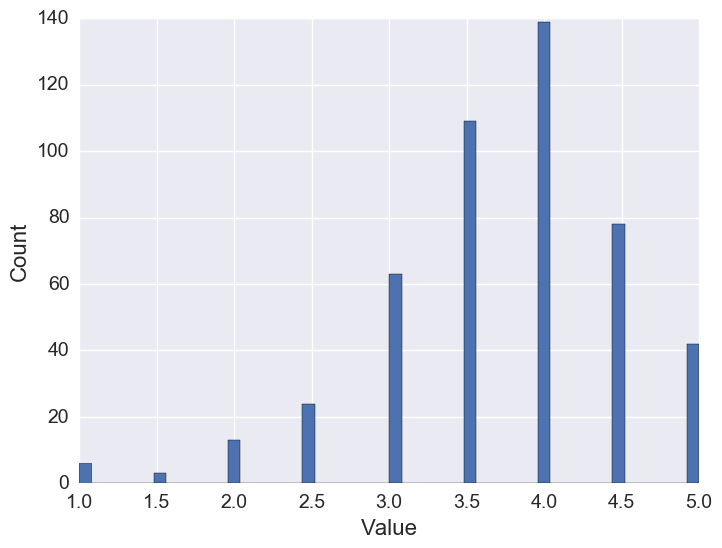

In [55]:
ratings = [d.rating for d in data]
plt.hist(ratings, bins=50);
plt.xlabel("Value")
plt.ylabel("Count")

In [27]:
# cannot use this one on our data because it is not json file
# either dump data to json or delete this
def parse_api_response(data, field='url'):
    """
    Parse Yelp API results to extract restaurant URLs.
    
    Args:
        data (string): String of properly formatted JSON.

    Returns:
        (list): list of URLs as strings from the input JSON.
    """
    
    data = json.loads(data)
    return [b[field] for b in data['businesses']]

In [31]:
data = '''{"businesses": [ {"url": "www.test.com"}, {"url": "www.test2.com"} ] }'''
parse_api_response(data)

[u'www.test.com', u'www.test2.com']

---

### Parse a Yelp restaurant Page

After we get the distribution of rating, in other words, the definition of success. Then we can deal with the source data. The first data we want to analyze is the review data. Review data can only be fetched by parsing the page.

We want to implement a function with such input and output. The input is the url of restaurant and we want the get the return as a json with contains some infomation like review_id, text which is good at future analysis.

```python
# Input:
    restuanrant url
# Output

[{
    'review_id': '12345'
    'user_id': '6789'
    'rating': 4.7
    'date': '2016-01-23'
    'text': "Wonderful!"
},{}...]
```


In [79]:
def createmap(one):
        dic = {
        'review_id': one["data-review-id"],
        'user_id': one['data-signup-object'].split(':')[1],
        # TODO rating and date field fails somehow!!!!
#         'rating': float(one.find_all("div", class_="rating-very-large")[0].meta['content']),
#         'date': one.find_all("span", class_="rating-qualifier")[0].meta["content"],
        'text': one.find_all("div", class_="review-content")[0].p.getText()
        }
        return dic
    
def parse_page(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    soup = BeautifulSoup(html,"html.parser")

    all_review = soup.find_all("div", class_="review")
    nextpage = soup.find_all("a", class_="next")
    if nextpage:
        nextpage = nextpage[0]["href"]
    else:
        nextpage = None
    reviews = map(createmap, all_review[1:])
    return reviews, nextpage


### Extract all of the Yelp reviews for a Single Restaurant

After we parse the page, then we can try to get the yelp reivews for this restaurant.

In [78]:
def extract_reviews(url):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    
    all_reviews = []
    nextpage = url
    while nextpage:
        res = requests.get(nextpage)
        html = res.content
        
        reviews, nextpage = parse_page(html)
        all_reviews += reviews
    return all_reviews

extract_reviews('https://www.yelp.com/biz/the-porch-at-schenley-pittsburgh')

TypeError: 'NoneType' object has no attribute '__getitem__'